In [1]:
import pymc as pm
import scipy.stats as stats
import bambi as bmb
import pandas as pd
import numpy as np
from data335 import lm, stan_lm, bambi_lm, mad
from matplotlib import pyplot as plt

In [2]:
with pm.Model():
    mu = pm.Normal("mu", mu=0.524, sigma=0.041)
    x = pm.Normal("x", mu=mu, sigma=0.025, observed=[0.475])
    idata = pm.sample()

mu = idata["posterior"].data_vars["mu"].to_numpy().ravel()
print()
print(f"mu.mean() = {mu.mean():.3f}, mu.std() = {mu.std():.3f}")
print(f"np.median(mu) = {np.median(mu):.3f}, mad(mu) = {mad(mu):.3f}")

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.



mu.mean() = 0.487, mu.std() = 0.021
np.median(mu) = 0.487, mad(mu) = 0.020


In [3]:
with pm.Model():
    mu = pm.Normal("mu", mu=0.524, sigma=0.041)
    x = pm.Normal("x", mu=mu, sigma=0.075, observed=[0.475])
    idata = pm.sample()

mu = idata["posterior"].data_vars["mu"].to_numpy().ravel()
print()
print(f"mu.mean() = {mu.mean():.3f}, mu.std() = {mu.std():.3f}")
print(f"np.median(mu) = {np.median(mu):.3f}, mad(mu) = {mad(mu):.3f}")

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.



mu.mean() = 0.513, mu.std() = 0.037
np.median(mu) = 0.513, mad(mu) = 0.037


In [4]:
with pm.Model():
    p = pm.Normal("p", mu=0.524, sigma=0.041)  # prior
    y = pm.Binomial("y", n=400, p=p, observed=[np.round(0.475 * 400)])  # data
    posterior = pm.sample()["posterior"]  # posterior

p = posterior.data_vars["p"].to_numpy().ravel()
print()
print(f"p.mean() = {p.mean():.3f}, p.std() = {p.std():.3f}")
print(f"np.median(p) = {np.median(p):.3f}, mad(p) = {mad(p):.3f}")

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.



p.mean() = 0.488, p.std() = 0.022
np.median(p) = 0.489, mad(p) = 0.022


In [5]:
with pm.Model():
    p = pm.Normal("p", mu=0.524, sigma=0.041)  # prior
    y = pm.Binomial("y", n=44, p=p, observed=[np.round(0.475 * 44)])  # data
    posterior = pm.sample()["posterior"]  # posterior

p = posterior.data_vars["p"].to_numpy().ravel()
print()
print(f"p.mean() = {p.mean():.3f}, p.std() = {p.std():.3f}")
print(f"np.median(p) = {np.median(p):.3f}, mad(p) = {mad(p):.3f}")

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.



p.mean() = 0.511, p.std() = 0.036
np.median(p) = 0.511, mad(p) = 0.037


In [6]:
# Hat tip John D. Cook!
# https://www.johndcook.com/blog/2021/04/07/beta-given-mean-variance/

mu = 0.524
sigma = 0.041

a = mu * (mu * (1 - mu) / sigma**2 - 1)
b = a * (1 - mu) / mu

assert np.allclose(a / (a + b), [mu, stats.beta(a, b).mean()])
assert np.allclose(
    np.sqrt(a * b / (a + b) ** 2 / (a + b + 1)), [sigma, stats.beta(a, b).std()]
)

In [7]:
with pm.Model():
    p = pm.Beta("p", alpha=a, beta=b)  # prior
    y = pm.Binomial("y", n=400, p=p, observed=[np.round(0.475 * 400)])  # data
    posterior = pm.sample()["posterior"]  # posterior

p = posterior.data_vars["p"].to_numpy().ravel()
print()
print(f"p.mean() = {p.mean():.3f}, p.std() = {p.std():.3f}")
print(f"np.median(p) = {np.median(p):.3f}, mad(p) = {mad(p):.3f}")

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.



p.mean() = 0.488, p.std() = 0.021
np.median(p) = 0.488, mad(p) = 0.021


In [8]:
a, b

(77.22625342058299, 70.15209280190363)

In [9]:
y0 = np.round(a)
n0 = np.round(a + b)
p0 = y0 / n0
se0 = np.sqrt(p0 * (1 - p0) / n0)
y0, n0, se0

(77.0, 147.0, 0.041192521824455666)

In [10]:
y = 190
n = 400

In [11]:
p = (y + y0) / (n + n0)
se = np.sqrt(p * (1 - p) / (n + n0))
p, se

(0.48811700182815354, 0.02137241787024956)

#### Sex ratio logistic regression

In [12]:
from sklearn.linear_model import LogisticRegression

In [13]:
N = 3000
n1 = 300
y1 = int(np.round(0.44 * n1))
n0 = N - n1
y0 = int(np.round(0.52 * n0))

X = np.concatenate([np.zeros(n0), np.ones(n1)])
Y0 = np.zeros(n0)
Y0[:y0] = 1
Y1 = np.zeros(n1)
Y1[:y1] = 1
Y = np.concatenate([Y0, Y1])

In [14]:
model = LogisticRegression()
model.fit(X.reshape(-1, 1), Y)
model.coef_

array([[-0.31538062]])

### Chapter 10

In [15]:
from sklearn.linear_model import LinearRegression
from matplotlib.axes import Axes
from numbers import Real
from sklearn.utils.validation import check_is_fitted
from typing import Any

In [16]:
kidiq = pd.read_csv("../data/kidiq.csv")
kidiq

,kid_score,mom_hs,mom_iq,mom_work,mom_age
0,65,1,121.117529,4,27
1,98,1,89.361882,4,25
2,85,1,115.443165,4,27
3,83,1,99.449639,3,25
4,115,1,92.745710,4,27
...,...,...,...,...,...
429,94,0,84.877412,4,21
430,76,1,92.990392,4,23
431,50,0,94.859708,2,24
432,88,1,96.856624,2,21


In [17]:
kid_score = kidiq["kid_score"]
mom_hs = kidiq[["mom_hs"]]
mom_iq = kidiq[["mom_iq"]]

mom_hs_model = LinearRegression()
mom_hs_model.fit(mom_hs, kid_score)
a_hs = mom_hs_model.intercept_
b_hs = mom_hs_model.coef_[0]

mom_iq_model = LinearRegression()
mom_iq_model.fit(mom_iq, kid_score)
a_iq = mom_iq_model.intercept_
b_iq = mom_iq_model.coef_[0]

In [18]:
def plot_regression_line(
    model, ax: Axes | None = None, xlim: tuple[Any, Any] | None = None, **kwargs
):
    if isinstance(model, LinearRegression):
        check_is_fitted(estimator=model, attributes=("intercept_", "coef_"))
        a = model.intercept_
        b = model.coef_[0]
    else:
        a = model[0]
        b = model[1]
    ax = plt.gca() if ax is None else ax
    if xlim is not None:
        xmin = xlim[0]
        xmax = xlim[1]
    else:
        xmin, xmax = ax.get_xlim()
    ax.plot([xmin, xmax], [a + b * xmin, a + b * xmax], **kwargs)

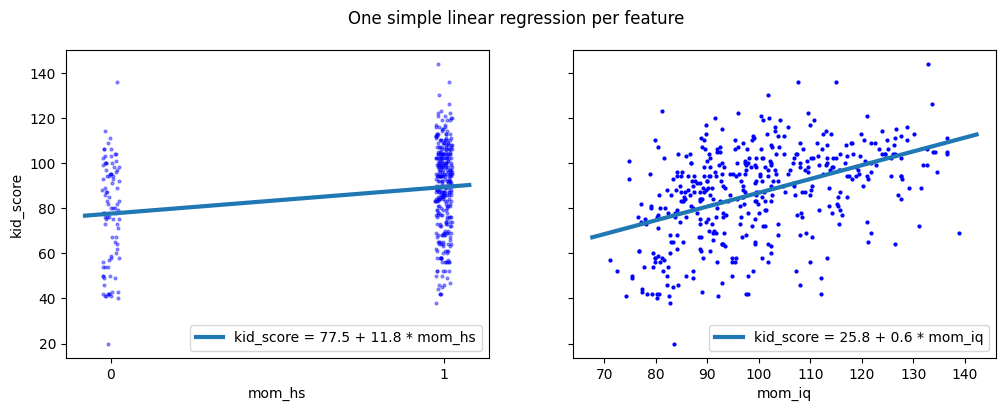

In [19]:
fig, (ax_hs, ax_iq) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12, 4))

fig.suptitle("One simple linear regression per feature")

jitter = 0.05 * np.random.uniform(-0.5, 0.5, size=mom_hs.shape)
ax_hs.scatter(mom_hs + jitter, kid_score, s=4, color=(0, 0, 1, 0.4))
ax_hs.set_xlabel("mom_hs")
ax_hs.set_xticks([0, 1])
ax_hs.set_ylabel("kid_score")
plot_regression_line(
    mom_hs_model, ax=ax_hs, lw=3, label=f"kid_score = {a_hs:.1f} + {b_hs:.1f} * mom_hs"
)
ax_hs.legend(loc="lower right")

kidiq.plot.scatter("mom_iq", "kid_score", ax=ax_iq, s=4, color=(0, 0, 1))
plot_regression_line(
    mom_iq_model, ax=ax_iq, lw=3, label=f"kid_score = {a_iq:.1f} + {b_iq:.1f} * mom_iq"
)
ax_iq.legend(loc="lower right")
plt.show()

#### Linear regression with two predictors

In [20]:
model = LinearRegression()
model.fit(kidiq[["mom_hs", "mom_iq"]], kidiq["kid_score"])
a = model.intercept_
b = model.coef_[0]
c = model.coef_[1]
print(
    f"kid_score   =   {a:.1f}   +   {b:.1f} * mom_hs   +   {c:.1f} * mom_iq   +   error"
)

kid_score   =   25.7   +   6.0 * mom_hs   +   0.6 * mom_iq   +   error


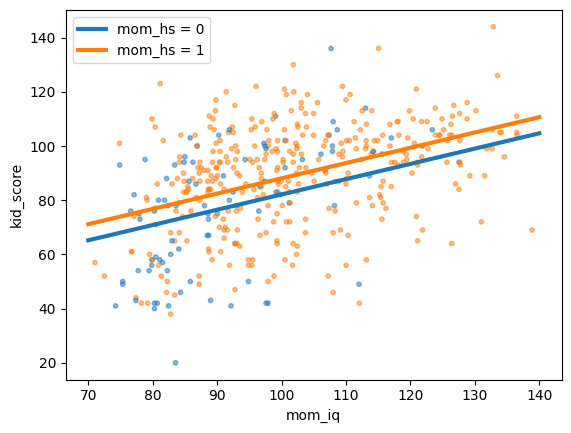

In [21]:
kidiq.plot.scatter(
    "mom_iq",
    "kid_score",
    s=10,
    c=["C0" if x == 0 else "C1" for x in kidiq["mom_hs"]],
    alpha=0.5,
)
plot_regression_line((a, c), lw=3, label="mom_hs = 0", xlim=(70, 140))
plot_regression_line((a + b, c), lw=3, label="mom_hs = 1", xlim=(70, 140))
plt.legend()
plt.show()

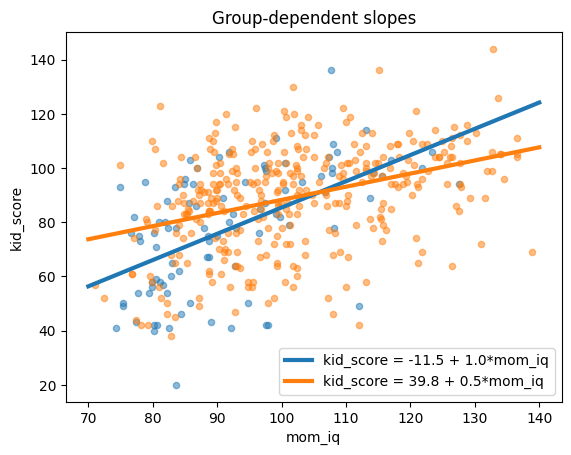

In [22]:
ax = plt.gca()
for hs, group in kidiq.groupby("mom_hs"):
    group.plot.scatter("mom_iq", "kid_score", color=f"C{hs}", alpha=0.5, ax=ax)
    model = LinearRegression()
    model.fit(group[["mom_iq"]], group["kid_score"])
    a = model.intercept_
    b = model.coef_[0]
    plot_regression_line(
        model,
        lw=3,
        ax=ax,
        xlim=(70, 140),
        label=f"kid_score = {a:.1f} + {b:.1f}*mom_iq",
    )
ax.legend()
ax.set_title("Group-dependent slopes")
plt.show()

In [23]:
kidiq["mom_hs:mom_iq"] = kidiq["mom_hs"] * kidiq["mom_iq"]

model = LinearRegression()
model.fit(kidiq[["mom_hs", "mom_iq", "mom_hs:mom_iq"]], kidiq["kid_score"])
a = model.intercept_
b = model.coef_[0]
c = model.coef_[1]
d = model.coef_[2]
print(
    f"kid_score  =  {a:.1f}  +  {b:.1f} * mom_hs  +  {c:.1f} * mom_iq  +  {d:.1f} * mom_hs:mom_iq  +   error"
)
print("\nIf mom_hs = 0:")
print(f"kid_score  =  {a:.1f}  +  {c:.1f} * mom_iq  +  error")
print("\nIf mom_hs = 1:")
print(f"kid_score  =   {a + b:.1f}  +  {c + d:.1f} * mom_iq  +  error")

kid_score  =  -11.5  +  51.3 * mom_hs  +  1.0 * mom_iq  +  -0.5 * mom_hs:mom_iq  +   error

If mom_hs = 0:
kid_score  =  -11.5  +  1.0 * mom_iq  +  error

If mom_hs = 1:
kid_score  =   39.8  +  0.5 * mom_iq  +  error


In [24]:
lm("kid_score ~ mom_hs + mom_iq + mom_hs:mom_iq", kidiq)

,estimate,standard error,t-statistic,p-value
Intercept,-11.482021,13.757974,-0.834572,0.404422
mom_hs,51.268223,15.337581,3.342654,0.000902
mom_iq,0.968889,0.148344,6.53138,0.0
mom_hs:mom_iq,-0.484275,0.162217,-2.98535,0.002994
sigma,17.971466,,,


In [25]:
stan_lm("kid_score ~ mom_hs + mom_iq + mom_hs:mom_iq", kidiq)

17:50:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:50:04 - cmdstanpy - INFO - CmdStan done processing.


,median,mad_sd
Intercept,-11.189350,13.681008
mom_hs,51.088250,15.336705
mom_iq,0.966405,0.148898
mom_hs:mom_iq,-0.482335,0.161301
sigma,18.029450,0.614761


In [26]:
bambi_lm("kid_score ~ mom_hs + mom_iq + mom_hs:mom_iq", kidiq)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, mom_hs, mom_iq, mom_hs:mom_iq]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


,median,mad_sd
sigma,18.012380,0.616767
Intercept,-10.269164,13.362898
mom_hs,49.587828,15.282114
mom_iq,0.956743,0.144940
mom_hs:mom_iq,-0.468033,0.160784


#### Height/Weight/Ethnicity

In [67]:
earnings = pd.read_csv("../data/earnings.csv")
mean_height = earnings["height"].mean()
print(f"mean_height = {mean_height:.1f}")
earnings["centered_height"] = earnings["height"] - mean_height

mean_height = 66.6


In [68]:
fit = bambi_lm("weight ~ centered_height", earnings, dropna=True)
fit

Automatically removing 27/1816 rows from the dataset.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, centered_height]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,median,mad_sd
sigma,28.951925,0.480919
Intercept,156.178066,0.687979
centered_height,4.948108,0.173555


In [69]:
newdata = pd.DataFrame({"centered_height": [0, 70 - mean_height]})
weight = fit.posterior_predict(newdata)
weight.mean(axis=0)

array([156.18228704, 173.16098763])

In [70]:
from formulaic import ModelSpec, model_matrix

In [71]:
fit = lm("weight ~ centered_height", earnings, na_action="drop")
fit

,estimate,standard error,t-statistic,p-value
Intercept,156.188011,0.684523,228.170622,0.0
centered_height,4.949380,0.178467,27.732684,0.0
sigma,28.952420,,,


In [72]:
fit = lm("weight ~ centered_height + male", earnings, na_action="drop")
fit

,estimate,standard error,t-statistic,p-value
Intercept,151.746941,1.007163,150.667763,0.0
centered_height,3.887891,0.250869,15.497673,0.0
male,11.837092,1.985109,5.962944,0.0
sigma,28.676477,,,


In [73]:
newdata = pd.DataFrame(
    {"centered_height": [70 - mean_height, 70 - mean_height], "male": [0, 1]}
)
fit.predict(newdata)

array([165.0869475 , 176.92403928])

In [74]:
fit = lm("weight ~ centered_height + male + C(ethnicity)", earnings, na_action="drop")
fit

,estimate,standard error,t-statistic,p-value
Intercept,156.519713,2.262769,69.171748,0.0
centered_height,3.852135,0.253067,15.221779,0.0
male,12.106320,1.99558,6.066567,0.0
C(ethnicity)[T.Hispanic],-6.152312,3.555277,-1.730473,0.083719
C(ethnicity)[T.Other],-12.261355,5.184896,-2.364822,0.018145
C(ethnicity)[T.White],-5.191391,2.267693,-2.289283,0.022179
sigma,28.636333,,,


In [75]:
earnings["ethnicity"] = earnings["ethnicity"].astype("category")

In [76]:
# Don't need the C
lm("weight ~ centered_height + male + ethnicity", earnings, na_action="drop")

,estimate,standard error,t-statistic,p-value
Intercept,156.519713,2.262769,69.171748,0.0
centered_height,3.852135,0.253067,15.221779,0.0
male,12.106320,1.99558,6.066567,0.0
ethnicity[T.Hispanic],-6.152312,3.555277,-1.730473,0.083719
ethnicity[T.Other],-12.261355,5.184896,-2.364822,0.018145
ethnicity[T.White],-5.191391,2.267693,-2.289283,0.022179
sigma,28.636333,,,


In [77]:
earnings["ethnicity"] = earnings["ethnicity"].cat.reorder_categories(
    ["White", "Black", "Hispanic", "Other"], ordered=True
)

In [78]:
lm("weight ~ centered_height + male + ethnicity", earnings, na_action="drop")

,estimate,standard error,t-statistic,p-value
Intercept,151.328322,1.041115,145.35215,0.0
centered_height,3.852135,0.253067,15.221779,0.0
male,12.106320,1.99558,6.066567,0.0
ethnicity[T.Black],5.191391,2.267693,2.289283,0.022179
ethnicity[T.Hispanic],-0.960921,2.939356,-0.326915,0.74377
ethnicity[T.Other],-7.069964,4.784855,-1.477571,0.139699
sigma,28.636333,,,
